<a href="https://colab.research.google.com/github/juharrais/visao_computacional/blob/main/Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.6 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# FIX PYTORCH VERSIONS to Colab Cuda
# Install PyTorch
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip3 install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.9 MB/s eta 0:10:49tcmalloc: large alloc 1147494400 bytes == 0x562bae222000 @  0x7f0606a73615 0x562b74b7717c 0x562b74c5747a 0x562b74b79f9d 0x562b74c6bd4d 0x562b74bedec8 0x562b74be8a2e 0x562b74b7b88a 0x562b74bedd30 0x562b74be8a2e 0x562b74b7b88a 0x562b74bea719 0x562b74c6cb76 0x562b74be9d95 0x562b74c6cb76 0x562b74be9d95 0x562b74c6cb76 0x562b74be9d95 0x562b74b7bce9 0x562b74bbf579 0x562b74b7a902 0x562b74bedc4d 0x562b74be8a2e 0x562b74b7b88a 0x562b74bea719 0x562b74be8a2e 0x562b74b7b88a 0x562b74be98f6 0x562b74b7b7aa 0x562b74be9b4f 0x562b74be8a2e
     |████████████████▌               | 1055.7 MB 1.4 MB/s eta 0:11:45tcmalloc: large alloc 1434370048 bytes == 0x562bf2878000 @  0x7f0606a73615 0x562b74b7717c 0x562b74c5747a 0x562b74b79f9d 0x562b74c6bd4d 0x562b74bedec8 0x562b74be8a2e 0x562b74b7b88a 0x562b74bedd30 0x562b74be8a2e 0x562b74b7b88a 0x562b74bea719 0x562b74c6cb76 0x562b74be9d

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6531, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 6531 (delta 3), reused 7 (delta 1), pack-reused 6509
Receiving objects: 100% (6531/6531), 13.08 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (4835/4835), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 497 kB 4.8 MB/s 
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.9.0+cu111 True
0.22.1


In [ ]:
!unzip '/content/drive/Shareddrives/Nuvens/datasets/Albedo(merged classes)_001_TrainVal.zip'

Archive:  /content/drive/Shareddrives/Nuvens/datasets/Albedo(merged classes)_001_TrainVal.zip
   creating: Albedo(merged classes)_001_TrainVal/
  inflating: Albedo(merged classes)_001_TrainVal/train.txt  
   creating: Albedo(merged classes)_001_TrainVal/.ipynb_checkpoints/
   creating: Albedo(merged classes)_001_TrainVal/img_dir/
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/126-2021-04-09-06-42.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/1010-11-18-00.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/141-2021-04-09-06-30.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/586-2021-05-10_15-32-00.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/411-06-41-00.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/1084-13-58-00.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/893-18-20-00.jpg  
  inflating: Albedo(merged classes)_001_TrainVal/img_dir/1027-10-30-00.jpg  
  inflating: Albedo(merged cla

## Run Inference with MMSeg trained weight

In [ ]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2022-03-25 00:18:16--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  7.96MB/s    in 24s     

2022-03-25 00:18:41 (7.79 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:

config_file = '/content/mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [ ]:

%cd /content/mmsegmentation

/content/mmsegmentation


In [ ]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [ ]:
# test a single image
img = '/content/mmsegmentation/demo/demo.png'
result = inference_segmentor(model, img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


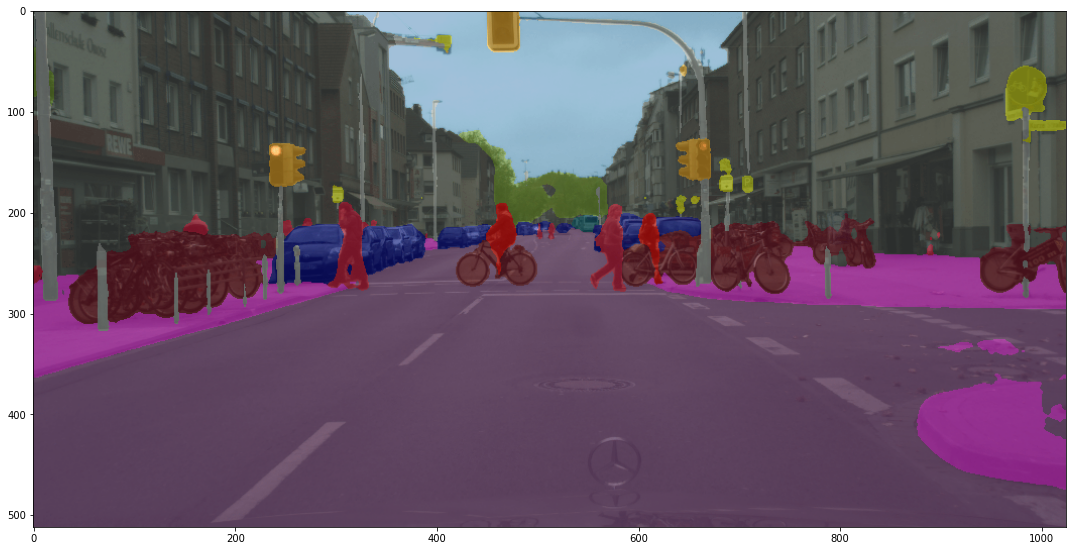

In [ ]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/docs/en/tutorials/new_dataset.md) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
%cd /content/

/content


In [ ]:
# download and unzip
#!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
#!tar xf stanford_background.tar.gz

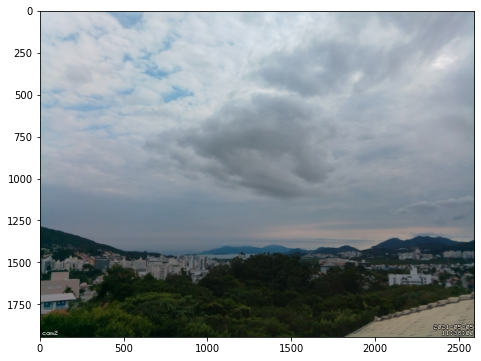

In [ ]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/img_dir/0-11-38-00.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'Albedo(merged classes)_001_TrainVal'
img_dir = 'img_dir'
ann_dir = 'ann_dir'
# define class and plaette for better visualization


classes = ('Ceu', 'Arvore', 'Estratocumuliformes', 'Estratiformes', 'Cirriformes', 'Cumuliformes')
palette = [[1,1,1], [136,179,66], [0, 119, 182], [0, 150, 232], 
           [101, 253, 220], [69, 62, 140]]


In [ ]:
import glob

for im in glob.glob('/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/ann_dir/*.png'):
    img = Image.open(im)
    img = img.convert('L')
    img.save(im)


In [ ]:
img = Image.open('/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/ann_dir/1017-2021-03-03-09-27.png')
np.array(img).shape


(1944, 2592)

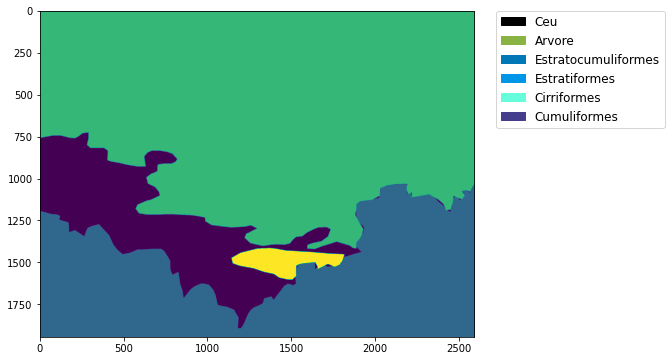

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/ann_dir/1017-2021-03-03-09-27.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('L')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(6)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
# split train/val set randomly
#split_dir = 'splits'
#mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
#filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
# #   osp.join(data_root, ann_dir), suffix='.png')]
#with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  ## select first 4/5 as train set
#  train_length = int(len(filename_list)*4/5)
#  f.writelines(line + '\n' for line in filename_list[:train_length])
#with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
 # # select last 1/5 as train set
#  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/mmsegmentation/configs/vit/upernet_vit-b16_mln_512x512_80k_ade20k.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)#cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/vit_base_patch16_224.pth',
    backbone=dict(
        type='VisionTransformer',
        img_size=(512, 512),
        patch_size=16,
        in_channels=3,
        embed_dims=768,
        num_layers=12,
        num_heads=12,
        mlp_ratio=4,
        out_indices=(2, 5, 8, 11),
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        with_cls_token=True,
        norm_cfg=dict(type='LN', requires_grad=True),
        act_cfg=dict(type='GELU'),
        norm_eval=False,
        interpolate_mode='bicubic'),
    neck=dict(
        type='MultiLevelNeck',
        in_channels=[768, 768, 768, 768],
        out_channels=768,
        scales=[4, 2, 1, 0.5]),
    decode_head=dict(
        type='UPerHead',
        in_channels=[768, 768, 768, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=

### Train and Evaluation

In [ ]:
%cd /content/mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-03-25 00:21:44,185 - mmseg - INFO - Loaded 1056 images
/content/mmsegmentation/mmseg/models/backbones/vit.py:193: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2022-03-25 00:21:46,104 - mmseg - INFO - Loaded 118 images
2022-03-25 00:21:46,111 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-03-25 00:21:46,332 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([6]).
size mismatch for decode_head.psp_modules.0.1.conv.weight: copy

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 1.6 task/s, elapsed: 72s, ETA:     0s

2022-03-25 00:26:57,865 - mmseg - INFO - per class results:
2022-03-25 00:26:57,869 - mmseg - INFO - 
+---------------------+-------+-------+
|        Class        |  IoU  |  Acc  |
+---------------------+-------+-------+
|         Ceu         | 50.14 | 75.05 |
|        Arvore       |  78.3 | 94.27 |
| Estratocumuliformes | 41.81 | 62.64 |
|    Estratiformes    |  0.23 |  0.24 |
|     Cirriformes     |  0.59 |  0.63 |
|     Cumuliformes    |  0.04 |  0.04 |
+---------------------+-------+-------+
2022-03-25 00:26:57,871 - mmseg - INFO - Summary:
2022-03-25 00:26:57,875 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 63.71 | 28.52 | 38.81 |
+-------+-------+-------+
2022-03-25 00:26:57,879 - mmseg - INFO - Iter(val) [118]	aAcc: 0.6371, mIoU: 0.2852, mAcc: 0.3881, IoU.Ceu: 0.5014, IoU.Arvore: 0.7830, IoU.Estratocumuliformes: 0.4181, IoU.Estratiformes: 0.0023, IoU.Cirriformes: 0.0059, IoU.Cumuliformes: 0.0004, Acc.Ceu: 0.7505, Acc.Arvore: 

Inference with trained model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/content/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result imag

<Figure size 576x432 with 0 Axes>

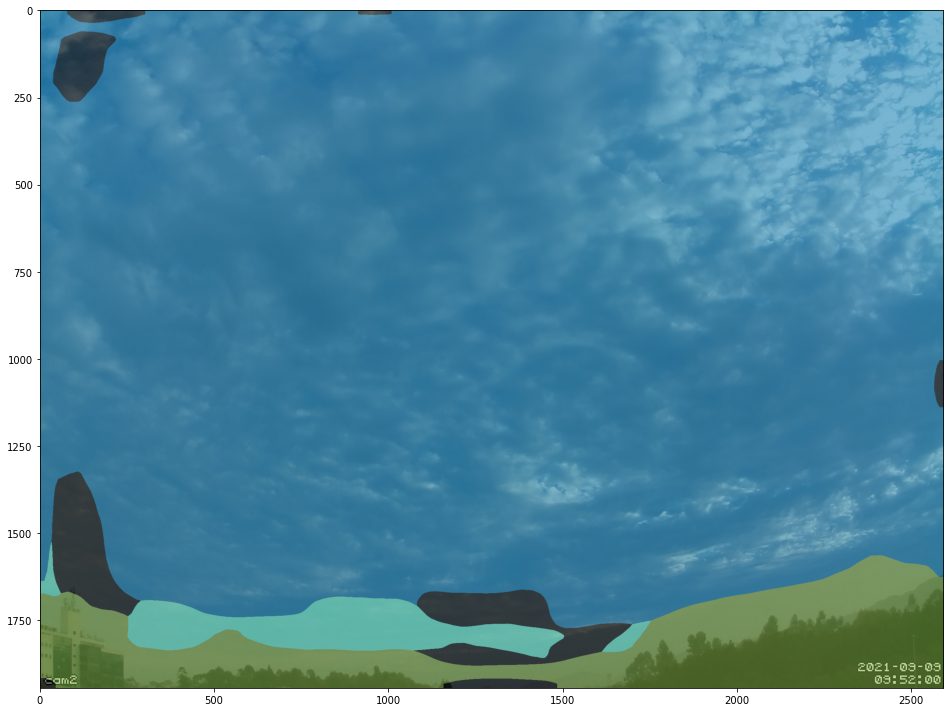

In [ ]:
img = mmcv.imread('/content/mmsegmentation/Albedo(merged classes)_001_TrainVal/img_dir/1001-09-52-00.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
